## QA_Predictive Modelling Round 2
This is the model performance improving round. The model training of this round will go through the following steps:
* Dataset inspection, 
    * checking the distribution of the numerical data 
    * pairplot to check correlations
    * check the frequency of the categorical data
    * check whether the lables are imbalanced
* Rescaling data to prevent disproportioned weights
* Feature enginnering
    * calculation of the date or other calculations between variables
    * feature cross (?)
    * one-hot-encoding / sparce encoding categorical features
* check categorical feature and label distribution in the training/validation/test sets (shuffle + y stratification)
    * splitting 110 : 30 : 30
    * --> 11 : 3 : 3 --> 0.6 : 0.2 : 0.2
* Checking feature importance with feature importance method / PCA
* Dimension reduction based on T-SNE / PCA
* Aim to have training and testing score to be at the similar range (over .80)
* The following models will be built: 
    * Logistic Regressor, Ridge classifier
    * KNN, SVM 
    * Random Forest Classfier (or other ensembles)
* Plot loss curve / variance-bias curve to check overfitting/underfitting 
* Build ML pipline if the model performance is ideal

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline


## Import data

In [4]:
# import hpi data
hpi_path = 'C:/Users/ywa/Documents/Data/Predictive modelling/training_feature_hpi.xlsx'

# import moodle data
moodle_path = 'C:/Users/ywa/Documents/Data/Predictive modelling/training_feature_Moodle.xlsx'

df_hpi = pd.read_excel(hpi_path, sheet_name = 'Sheet1')
df_moodle = pd.read_excel(moodle_path, sheet_name = 'Sheet1')


In [5]:
# inspect two dataframes
df_hpi.head()
print(df_hpi.info())

df_moodle.head()
print(df_moodle.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   title                        74 non-null     object        
 1   language                     74 non-null     object        
 2   published_sections           74 non-null     int64         
 3   enrollments_total            74 non-null     int64         
 4   records_of_achievement       74 non-null     int64         
 5   category                     74 non-null     object        
 6   Date go-live                 74 non-null     datetime64[ns]
 7   Approx. date last enrolment  74 non-null     datetime64[ns]
 8   Mean_Q1                      68 non-null     float64       
 9   Mean_Q4                      68 non-null     float64       
 10  Sum_Q1                       70 non-null     float64       
 11  Sum_Q4                       70 non-null     fl

## Data cleaning

In [7]:
# timedelta for the duration of hpi data
df_hpi['duration'] = df_hpi['Approx. date last enrolment'] - df_hpi['Date go-live']

df_hpi['duration'] = df_hpi['duration'].astype('str')
df_hpi['duration'] = df_hpi['duration'].str.replace(' days', '')
df_hpi['duration'] = df_hpi['duration'].astype('int')

df_hpi.head()

,title,language,published_sections,enrollments_total,records_of_achievement,category,Date go-live,Approx. date last enrolment,Mean_Q1,Mean_Q4,Sum_Q1,Sum_Q4,label,duration
0,"""Learn2Trust - Vertrauen durch Verständnis von...",de,6,338,151,Med,2023-05-26,2024-12-03,3.083333,2.833333,37.0,34.0,Archived,557
1,"""Practising Artificial Intelligence""",en,7,294,20,Studieren,2023-09-01,2024-10-16,3.000000,3.000000,3.0,3.0,Archived,411
2,"""KI und Ethik""",de,44,131,0,Ethik,2020-06-26,2022-07-19,4.000000,4.000000,8.0,8.0,Archived,753
3,"""Learning Analytics für Lehrkräfte""",de,13,767,73,Schule,2023-09-12,2024-07-31,3.000000,2.480000,75.0,62.0,No update,323
4,"""Bildungsdatenkompetenz""",de,6,182,28,Schule,2023-09-01,2024-11-29,3.000000,2.571429,21.0,18.0,Archived,455


In [8]:
# concatenate two data sets (rename cols when necessary)

# check the col-names of two dataframes
print(df_hpi.columns)
print(df_moodle.columns)

# exclude columns from two dataframes
df_hpi = df_hpi.drop(['Approx. date last enrolment', 'Date go-live', 'Sum_Q1', 'Sum_Q4'], axis = 1)
df_moodle = df_moodle.drop(['courseID'], axis = 1)

print(df_hpi.shape)
print(df_moodle.shape)

# rename column
df_hpi = df_hpi.rename(columns = {'title' : 'courseName'})

print(df_hpi.info())
print(df_moodle.info())

df_data = pd.concat([df_hpi, df_moodle])

df_data.head()

Index(['title', 'language', 'published_sections', 'enrollments_total',
       'records_of_achievement', 'category', 'Date go-live',
       'Approx. date last enrolment', 'Mean_Q1', 'Mean_Q4', 'Sum_Q1', 'Sum_Q4',
       'label', 'duration'],
      dtype='object')
Index(['courseID', 'courseName', 'category', 'enrollments_total', 'language',
       'records_of_achievement', 'Mean_Q1', 'Mean_Q4', 'published_sections',
       'duration', 'label'],
      dtype='object')
(74, 10)
(41, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   courseName              74 non-null     object 
 1   language                74 non-null     object 
 2   published_sections      74 non-null     int64  
 3   enrollments_total       74 non-null     int64  
 4   records_of_achievement  74 non-null     int64  
 5   category                74 non-nul

,courseName,language,published_sections,enrollments_total,records_of_achievement,category,Mean_Q1,Mean_Q4,label,duration
0,"""Learn2Trust - Vertrauen durch Verständnis von...",de,6,338,151,Med,3.083333,2.833333,Archived,557
1,"""Practising Artificial Intelligence""",en,7,294,20,Studieren,3.000000,3.000000,Archived,411
2,"""KI und Ethik""",de,44,131,0,Ethik,4.000000,4.000000,Archived,753
3,"""Learning Analytics für Lehrkräfte""",de,13,767,73,Schule,3.000000,2.480000,No update,323
4,"""Bildungsdatenkompetenz""",de,6,182,28,Schule,3.000000,2.571429,Archived,455


In [9]:
# inspect missing values
print(df_data.shape)

df_data.isnull().sum()

na_mask = df_data[['Mean_Q1', 'Mean_Q4']].isnull()

df_missing = df_data[na_mask.any(axis = 1)]

df_missing

(115, 10)


,courseName,language,published_sections,enrollments_total,records_of_achievement,category,Mean_Q1,Mean_Q4,label,duration
11,"""Künstliche Intelligenz in der Gesundheitsvers...",de,18,689,84,Med,NaN,NaN,No update,655
13,"""Lernfabrik 4.0 - Steuerung , Monitoring und N...",de,9,88,0,Industry40,NaN,NaN,Archived,294
19,"""Dr. med. KI - Basler Modul""",de,9,234,206,Med,NaN,NaN,No update,647
24,"""Deep Learning mit Tensorflow, Keras und Tenso...",de,12,766,85,ML,NaN,NaN,Update,796
27,"""Foundations of Artificial Intelligence VI""",en,7,205,19,Studieren,NaN,NaN,No update,872
39,"""Applied Edge AI: Deep Learning Outside of the...",en,10,540,34,ML,NaN,NaN,Archived,225


In [10]:
# interpolation of missing values -- category, label depended means
interpolation= df_data.groupby(['category', 'label'])['Mean_Q1', 'Mean_Q4'].mean()
interpolation


C:\Users\ywa\AppData\Local\Temp\ipykernel_32992\1454164668.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  interpolation= df_data.groupby(['category', 'label'])['Mean_Q1', 'Mean_Q4'].mean()


Mean_Q1   Mean_Q4
category      label                        
Data Literacy Archived   3.000000  2.844444
              No Update  3.400000  2.800000
              No update  3.185605  2.675893
Ethik         Archived   3.505529  3.247590
              No Update  3.392005  3.172975
              No update  3.144737  2.934211
              Update     3.282609  3.043478
Industry40    Archived   3.045455  2.559596
              No Update  3.529167  2.997500
              No update  3.491837  3.365306
              Update     3.334750  2.918440
ML            Archived   3.555556  2.851852
              No Update  3.372396  3.068576
              Update     3.127548  2.847908
Med           Archived   3.254902  2.938725
              No Update  3.210930  2.996493
              No update  3.193256  2.816321
              Update     3.197154  2.846637
Robotik       Archived   3.750000  3.000000
              Update     3.583333  3.375000
Schule        Archived   3.227273  2.857143
              No update  3.198413  2.787619
              Update     3.211843  2.950279
Studieren     Archived   3.157895  2.894737
              Archived   3.333333  3.000000
              No Update  3.542683  3.268293
              No update  2.880256  2.827236
              Update     2.991851  2.526307
ÜberKI        Archived   3.294118  3.088235
              No Update  3.477524  3.001229
              No update  3.457266  2.704772
              Update     3.277462  2.903640

In [11]:
na_cols = ['Mean_Q1', 'Mean_Q4']

for col in na_cols:
    df_missing.loc[:, col] = df_missing.apply(lambda row : interpolation.loc[(row['category'], row['label']), col] if (row['category'], row['label']) in interpolation.index and pd.isna(row[col])else row[col], axis = 1)
            
df_missing

C:\Users\ywa\AppData\Local\Temp\ipykernel_32992\2584702756.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_missing.loc[:, col] = df_missing.apply(lambda row : interpolation.loc[(row['category'], row['label']), col] if (row['category'], row['label']) in interpolation.index and pd.isna(row[col])else row[col], axis = 1)
C:\Users\ywa\AppData\Local\Temp\ipykernel_32992\2584702756.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_missing.loc[:, col] = df_missing.apply(lambda row : interpolation.loc[(r

,courseName,language,published_sections,enrollments_total,records_of_achievement,category,Mean_Q1,Mean_Q4,label,duration
11,"""Künstliche Intelligenz in der Gesundheitsvers...",de,18,689,84,Med,3.193256,2.816321,No update,655
13,"""Lernfabrik 4.0 - Steuerung , Monitoring und N...",de,9,88,0,Industry40,3.045455,2.559596,Archived,294
19,"""Dr. med. KI - Basler Modul""",de,9,234,206,Med,3.193256,2.816321,No update,647
24,"""Deep Learning mit Tensorflow, Keras und Tenso...",de,12,766,85,ML,3.127548,2.847908,Update,796
27,"""Foundations of Artificial Intelligence VI""",en,7,205,19,Studieren,2.880256,2.827236,No update,872
39,"""Applied Edge AI: Deep Learning Outside of the...",en,10,540,34,ML,3.555556,2.851852,Archived,225


In [14]:
# replace rows in the df_data with the missing
print(df_data.shape)
df_data =  pd.concat([df_data, df_missing], axis = 0)
print(df_data.shape)
df_data = df_data.drop_duplicates(subset = ['courseName', 'enrollments_total'], keep = 'last')
print(df_data.shape)

(115, 10)
(121, 10)
(115, 10)


In [15]:
# string cleaning - no space
df_data['language'] = df_data['language'].str.strip()
df_data['label'] = df_data['label'].str.strip()

## Data inspection / EDA

In [16]:
# data type check
df_data.info()

print(df_data.label.unique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115 entries, 0 to 39
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   courseName              115 non-null    object 
 1   language                115 non-null    object 
 2   published_sections      115 non-null    int64  
 3   enrollments_total       115 non-null    int64  
 4   records_of_achievement  115 non-null    int64  
 5   category                115 non-null    object 
 6   Mean_Q1                 115 non-null    float64
 7   Mean_Q4                 115 non-null    float64
 8   label                   115 non-null    object 
 9   duration                115 non-null    int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 9.9+ KB
['Archived' 'No update' 'Update' 'No Update']


In [17]:
# numerical columns distribution check
df_data_num = df_data[['published_sections', 'enrollments_total', 'records_of_achievement', 'Mean_Q1', 'Mean_Q4', 'duration']]
df_data_num.head()
print(df_data_num.describe())


       published_sections  enrollments_total  records_of_achievement  \
count          115.000000         115.000000              115.000000   
mean             9.973913         955.347826               76.808696   
std              5.381027        1686.448058              121.918070   
min              4.000000          26.000000                0.000000   
25%              7.000000         222.500000                4.000000   
50%              8.000000         412.000000               26.000000   
75%             12.000000        1059.000000               85.500000   
max             44.000000       15470.000000              771.000000   

          Mean_Q1     Mean_Q4     duration  
count  115.000000  115.000000   115.000000  
mean     3.254754    2.918529   679.878261  
std      0.304228    0.317565   418.978418  
min      2.000000    2.000000    43.000000  
25%      3.085145    2.796552   293.500000  
50%      3.285714    2.937500   655.000000  
75%      3.456916    3.069048  1025.

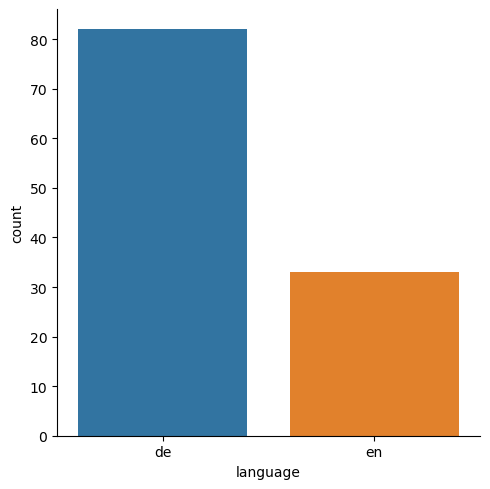

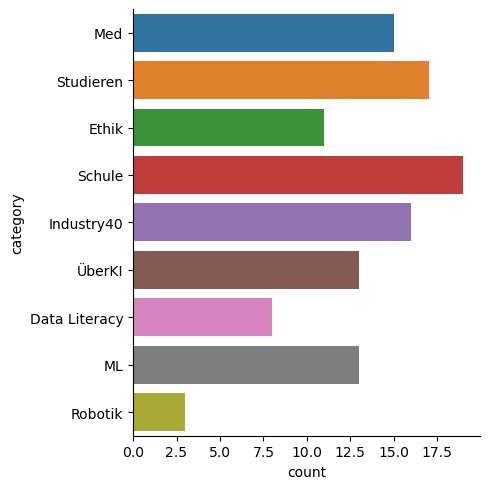

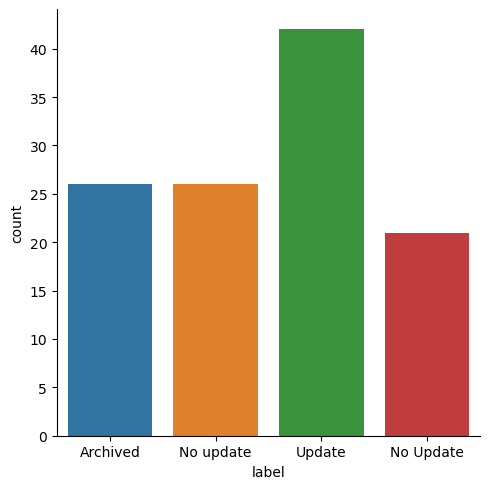

Update       42
Archived     26
No update    26
No Update    21
Name: label, dtype: int64

In [26]:
# visualisations

# for categorical features
# language
sns.catplot(data = df_data, x = 'language', kind = 'count')
plt.show()

# category
sns.catplot(data = df_data, y = 'category', kind = 'count')
plt.show()

# label
sns.catplot(data = df_data, x = 'label', kind = 'count')
plt.show()

df_data['label'].value_counts()


* there are significantly more DE content than the EN content
* the distribution of labels is unbalanced --> significantly unbalanced??

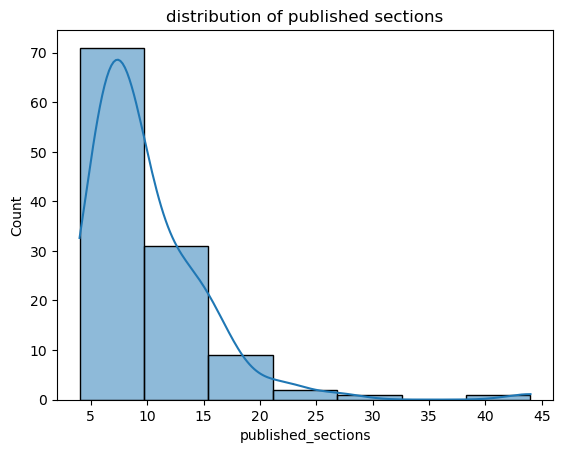

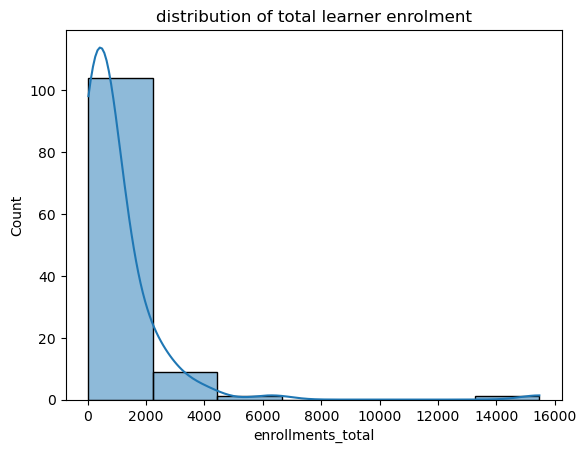

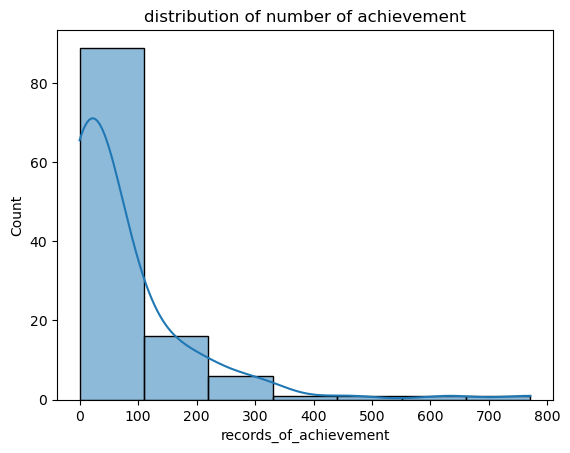

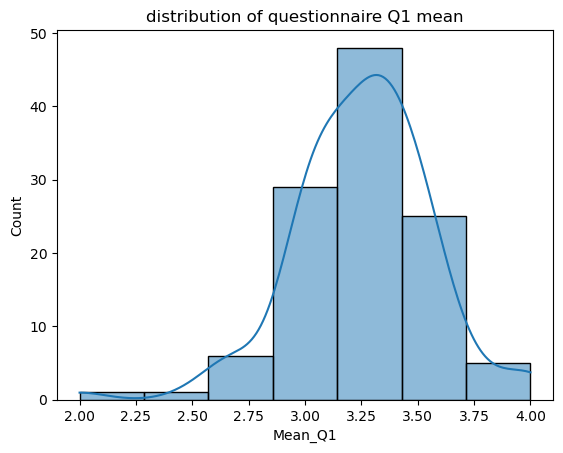

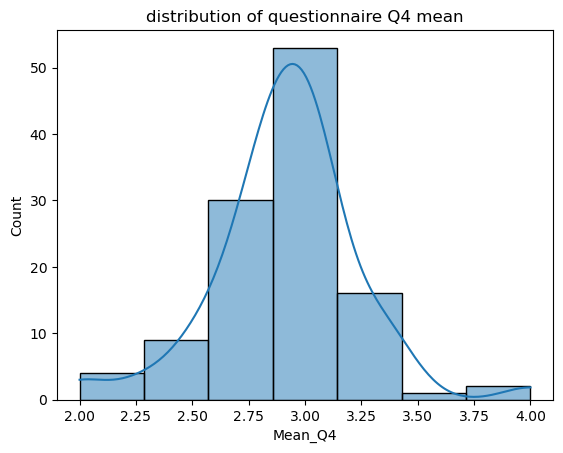

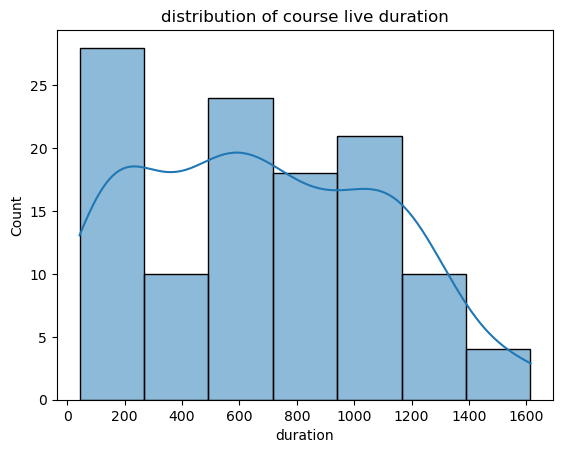

In [19]:
# for numeric variables

# published_sections
sns.histplot(data = df_data, x = 'published_sections', bins = 7, kde = True)
plt.title('distribution of published sections')
plt.show()

# enrollments_total
sns.histplot(data = df_data, x = 'enrollments_total', bins = 7, kde = True)
plt.title('distribution of total learner enrolment')
plt.show()

# records_of_achievement
sns.histplot(data = df_data, x = 'records_of_achievement', bins = 7, kde = True)
plt.title('distribution of number of achievement')
plt.show()

# Mean_Q1 
sns.histplot(data = df_data, x = 'Mean_Q1', bins = 7, kde = True)
plt.title('distribution of questionnaire Q1 mean')
plt.show()

# Mean_Q4 
sns.histplot(data = df_data, x = 'Mean_Q4', bins = 7, kde = True)
plt.title('distribution of questionnaire Q4 mean')
plt.show()

# duration
sns.histplot(data = df_data, x = 'duration', bins = 7, kde = True)
plt.title('distribution of course live duration')
plt.show()


* published_sections --> right skewed distribution

* enrollments_total --> right skewed distribution

* records_of_achievement --> right skewed distribution

* Mean_Q1 --> left skewed distribution

* Mean_Q4 --> no apparent skewness

* duration --> multimodal distribution

<Axes: >

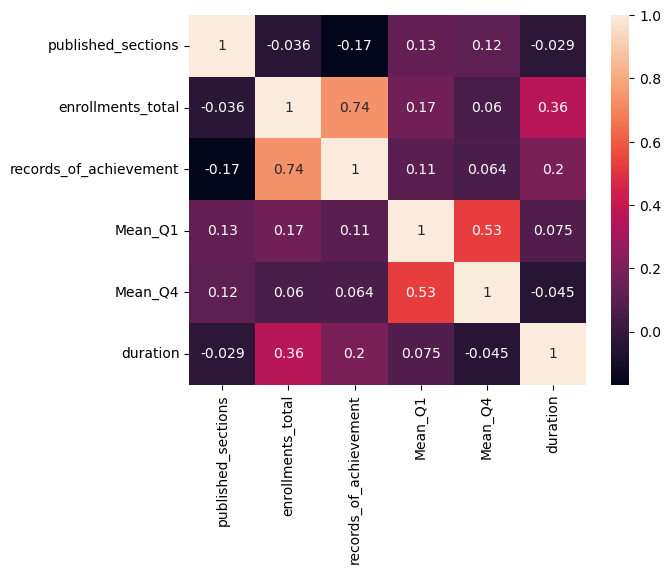

In [21]:
# correlation matrix
num_corr = df_data_num.corr()
num_corr

sns.heatmap(num_corr, annot = True)


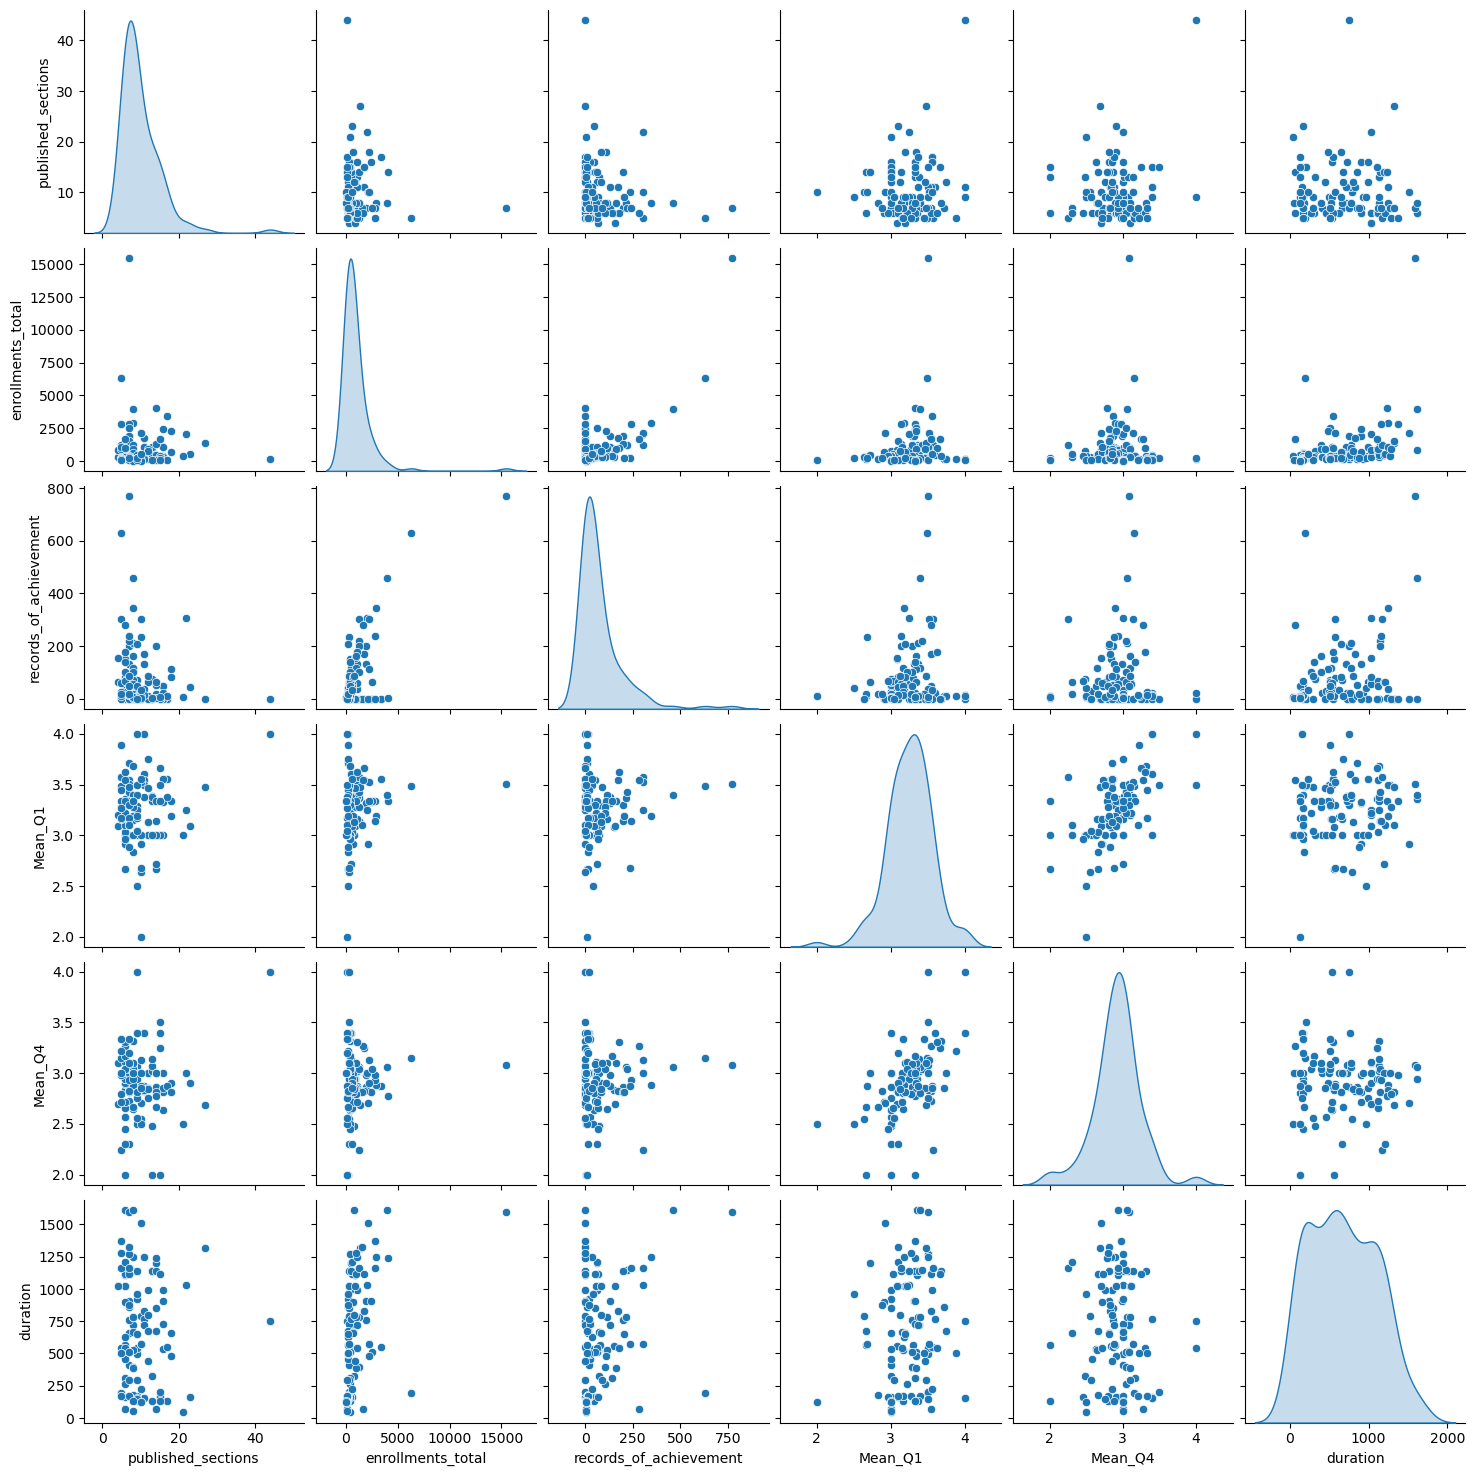

In [22]:
# pair plot for the numerical data
sns.pairplot(data = df_data_num, kind = 'scatter', diag_kind = 'kde')
plt.show()


visible correlations including:
* enrolments - number of records of achievement
* mean Q1 - mean Q4 (the rating of the course quality)

In [23]:
# check percentage of outliers in the numerical data set

# define outlier check function for data outside 1.5*IQR
def outlier_check_pct(data_series):
    '''This function calculate the percentage of the total outlier (1.5IQR) data point out of a pd.Series/np.array. 

    Arg: 
    data_series, an array-like list. 

    Output
    pct, a float ''' 
 
    q1 = np.quantile(data_series, 0.25)
    q3 = np.quantile(data_series, 0.75)
    IQR = q3 - q1
    upper_thred = q3 + IQR * 1.5
    lower_thred = q1 - IQR * 1.5
    total = len(data_series)
    upper_sum = sum(data_series > upper_thred)
    lower_sum = sum(data_series < lower_thred)
    counter = upper_sum + lower_sum
    pct = counter/total
    return pct
                   
# Percentage of the outliers --> which numeric feature can be clipped
published_sections_pct = outlier_check_pct(df_data.published_sections)
print(f'percentage of outliers in published_sections:{published_sections_pct}')

enrollments_total_pct = outlier_check_pct(df_data.enrollments_total)
print(f'percentage of outliers in enrollments_total:{enrollments_total_pct}')

records_of_achievement_pct = outlier_check_pct(df_data.records_of_achievement)
print(f'percentage of outliers in records_of_achievement:{records_of_achievement_pct}')

mean_Q1_pct = outlier_check_pct(df_data.Mean_Q1)
print(f'percentage of outliers in mean_Q1:{mean_Q1_pct}')

mean_Q4_pct = outlier_check_pct(df_data.Mean_Q4)
print(f'percentage of outliers in mean_Q4:{mean_Q4_pct}')

duration_pct = outlier_check_pct(df_data.duration)
print(f'percentage of outliers in duration:{duration_pct}')



percentage of outliers in published_sections:0.043478260869565216
percentage of outliers in enrollments_total:0.08695652173913043
percentage of outliers in records_of_achievement:0.10434782608695652
percentage of outliers in mean_Q1:0.017391304347826087
percentage of outliers in mean_Q4:0.0782608695652174
percentage of outliers in duration:0.0


The numerical features that needs clipping:
* published_sections
* enrollments_total
* records_of_achievement
* mean_Q1
* mean_Q4

--> clipping before Z-Score


## Data scaling
* clipping to minimise extreme outliers --> need to check how much percentage of data is in the range of normal distribution.
* or use z-score (not linear scaling due to extreme outliers)


In [18]:
# define function to get upper and lower clip points

def clip_upper_lower(data_series):
    q1 = np.quantile(data_series, 0.25)
    q3 = np.quantile(data_series, 0.75)
    IQR = q3 - q1
    upper_thred = q3 + 1.5 * IQR
    lower_thred = q1 - 1.5 * IQR
    return (lower_thred, upper_thred)
    
# test get upper and lower
print(clip_upper_lower(df_data.published_sections)[0])


-0.5


In [19]:
# define function for z-score...

def z_score(data_series):
    data_mean = data_series.mean()
    data_std = data_series.std()
    z = (data_series - data_mean) / data_std
    return z

# test get z score
print(z_score(df_data.published_sections))

0    -0.738505
1    -0.552666
2     6.323344
3     0.562362
4    -0.738505
        ...   
13   -0.180990
19   -0.180990
24    0.376524
27   -0.552666
39    0.004848
Name: published_sections, Length: 115, dtype: float64


In [20]:
# make a copy of the dataframe
df_copy = df_data.copy()

In [21]:
# clipping then z-score --> extreme outliers affect mean and distribution (published_sections, enrollments_total, records_of achievement)
# clipping
df_copy['published_sections'] = df_copy['published_sections'].clip(clip_upper_lower(df_copy.published_sections)[0], clip_upper_lower(df_copy.published_sections)[1])
df_copy['enrollments_total'] = df_copy['enrollments_total'].clip(clip_upper_lower(df_copy.enrollments_total)[0], clip_upper_lower(df_copy.enrollments_total)[1])
df_copy['records_of_achievement'] = df_copy['records_of_achievement'].clip(clip_upper_lower(df_copy.records_of_achievement)[0], clip_upper_lower(df_copy.records_of_achievement)[1])

# z-score
df_copy['published_sections'] = z_score(df_copy['published_sections'])
df_copy['enrollments_total'] = z_score(df_copy['enrollments_total'])
df_copy['records_of_achievement'] = z_score(df_copy['records_of_achievement'])



In [22]:
# z-score then clipping --> retain the distribution (Mean_Q1, Mean_Q4)
# z-score
df_copy['Mean_Q1'] = z_score(df_copy['Mean_Q1'])
df_copy['Mean_Q4'] = z_score(df_copy['Mean_Q4'])

# clipping
df_copy['Mean_Q1'] = df_copy['Mean_Q1'].clip(clip_upper_lower(df_copy.Mean_Q1)[0], clip_upper_lower(df_copy.Mean_Q1)[1])
df_copy['Mean_Q4'] = df_copy['Mean_Q4'].clip(clip_upper_lower(df_copy.Mean_Q4)[0], clip_upper_lower(df_copy.Mean_Q4)[1])


In [23]:
# z-score (duration)
df_copy['duration'] = z_score(df_copy['duration'])


In [24]:
df_copy.head()

,courseName,language,published_sections,enrollments_total,records_of_achievement,category,Mean_Q1,Mean_Q4,label,duration
0,"""Learn2Trust - Vertrauen durch Verständnis von...",de,-0.899377,-0.576303,1.262808,Med,-0.563462,-0.268277,Archived,-0.293281
1,"""Practising Artificial Intelligence""",en,-0.651644,-0.637813,-0.576523,Studieren,-0.837379,0.256551,Archived,-0.641747
2,"""KI und Ethik""",de,2.445012,-0.865680,-0.857337,Ethik,2.449634,1.761099,Archived,0.174524
3,"""Learning Analytics für Lehrkräfte""",de,0.834751,0.023419,0.167634,Schule,-0.837379,-1.380911,No update,-0.851782
4,"""Bildungsdatenkompetenz""",de,-0.899377,-0.794384,-0.464197,Schule,-0.837379,-1.093006,Archived,-0.536730


## Feature engineering

In [25]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115 entries, 0 to 39
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   courseName              115 non-null    object 
 1   language                115 non-null    object 
 2   published_sections      115 non-null    float64
 3   enrollments_total       115 non-null    float64
 4   records_of_achievement  115 non-null    float64
 5   category                115 non-null    object 
 6   Mean_Q1                 115 non-null    float64
 7   Mean_Q4                 115 non-null    float64
 8   label                   115 non-null    object 
 9   duration                115 non-null    float64
dtypes: float64(6), object(4)
memory usage: 9.9+ KB


Due to the high correlation (r = 0.74) between feature "enrollments_total" and "records_of_achievement". New feature "learning success" can be created

In [26]:
# create "learning_success" feature
df_copy['learning_success'] = df_data['records_of_achievement'] / df_data['enrollments_total']

df_data['learning_success'] = df_copy['learning_success']

print(df_data.columns)

df_copy['learning_success'].shape


Index(['courseName', 'language', 'published_sections', 'enrollments_total',
       'records_of_achievement', 'category', 'Mean_Q1', 'Mean_Q4', 'label',
       'duration', 'learning_success'],
      dtype='object')


(115,)

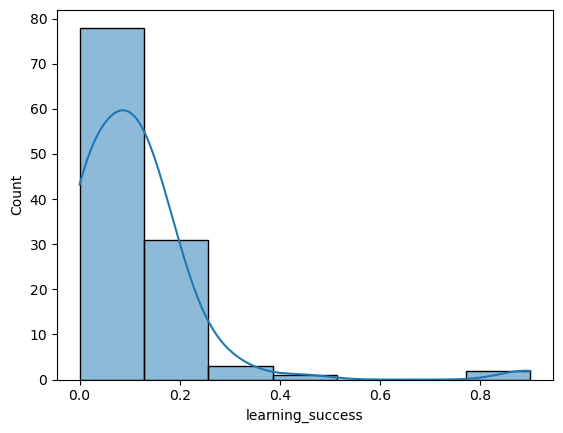

percentage of outliers in learning_success:0.02608695652173913


In [27]:
# inspect distribution, outliers of 'learning_success'
sns.histplot(data = df_copy, x = 'learning_success', bins = 7, kde = True)
plt.show()

learning_success_pct = outlier_check_pct(df_copy.learning_success)
print(f'percentage of outliers in learning_success:{learning_success_pct}')


<Axes: >

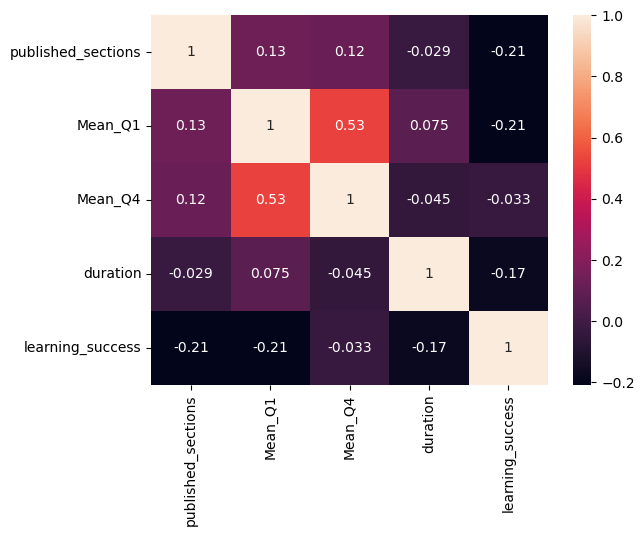

In [28]:
# correlation matrix

df_data_num = df_data[['published_sections', 'Mean_Q1', 'Mean_Q4', 'duration', 'learning_success']]

num_corr = df_data_num.corr()
num_corr

sns.heatmap(num_corr, annot = True)

* The distribution of the 'learning_success' is right skewed.
* No hight correlations found between 'learning_success' and other features.

In [29]:
# clipping and then z-score
df_copy['learning_success'] = df_copy['learning_success'].clip(clip_upper_lower(df_copy.learning_success)[0], clip_upper_lower(df_copy.learning_success)[1])

df_copy['learning_success'] = z_score(df_copy['learning_success'])

df_copy.head()


,courseName,language,published_sections,enrollments_total,records_of_achievement,category,Mean_Q1,Mean_Q4,label,duration,learning_success
0,"""Learn2Trust - Vertrauen durch Verständnis von...",de,-0.899377,-0.576303,1.262808,Med,-0.563462,-0.268277,Archived,-0.293281,2.795133
1,"""Practising Artificial Intelligence""",en,-0.651644,-0.637813,-0.576523,Studieren,-0.837379,0.256551,Archived,-0.641747,-0.395464
2,"""KI und Ethik""",de,2.445012,-0.865680,-0.857337,Ethik,2.449634,1.761099,Archived,0.174524,-1.182415
3,"""Learning Analytics für Lehrkräfte""",de,0.834751,0.023419,0.167634,Schule,-0.837379,-1.380911,No update,-0.851782,-0.081402
4,"""Bildungsdatenkompetenz""",de,-0.899377,-0.794384,-0.464197,Schule,-0.837379,-1.093006,Archived,-0.536730,0.597305


In [58]:
# select feature columns

df_features = df_copy.drop(labels = ['courseName', 'enrollments_total', 'label', 'records_of_achievement'], axis = 1)
print(df_features.shape)

# one-hot-encoding for the features
X = pd.get_dummies(df_features)
print(X.shape)

X.head()

(115, 7)
(115, 16)


,published_sections,Mean_Q1,Mean_Q4,duration,learning_success,language_de,language_en,category_Data Literacy,category_Ethik,category_Industry40,category_ML,category_Med,category_Robotik,category_Schule,category_Studieren,category_ÜberKI
0,-0.899377,-0.563462,-0.268277,-0.293281,2.795133,1,0,0,0,0,0,1,0,0,0,0
1,-0.651644,-0.837379,0.256551,-0.641747,-0.395464,0,1,0,0,0,0,0,0,0,1,0
2,2.445012,2.449634,1.761099,0.174524,-1.182415,1,0,0,1,0,0,0,0,0,0,0
3,0.834751,-0.837379,-1.380911,-0.851782,-0.081402,1,0,0,0,0,0,0,0,1,0,0
4,-0.899377,-0.837379,-1.093006,-0.536730,0.597305,1,0,0,0,0,0,0,0,1,0,0


In [59]:
# encode labels
labels = df_copy[['label']]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

y

C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 0, 0, 2, 0, 2, 2, 3, 2, 2, 2, 0, 3, 2, 0, 3, 0, 0, 2, 0, 2, 2,
       3, 2, 3, 0, 2, 3, 2, 0, 2, 2, 2, 2, 3, 3, 3, 3, 0, 3, 3, 2, 0, 0,
       0, 0, 0, 0, 3, 3, 2, 2, 2, 3, 3, 3, 2, 0, 0, 3, 0, 3, 2, 3, 3, 3,
       3, 3, 1, 3, 3, 1, 1, 3, 1, 1, 3, 1, 1, 3, 3, 1, 3, 1, 3, 0, 1, 1,
       3, 1, 1, 1, 3, 1, 1, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 1, 0, 0, 2,
       0, 2, 3, 2, 0])

## Split training/validation/test sets

In [32]:
# set random_state
rand_state = 7

# split data set: traing + validation/test
print(df_copy.shape)

X_train, X_vt, y_train, y_vt = train_test_split(X, y, test_size = 0.4, stratify = y, shuffle = True, random_state = rand_state)

print(X_train.shape)
print(X_vt.shape)
print(y_train.shape)
print(y_vt.shape)


(115, 11)
(69, 16)
(46, 16)
(69,)
(46,)


In [33]:
# split data set: validation/test

X_validation, X_test, y_validation, y_test = train_test_split(X_vt, y_vt, test_size = 0.5, stratify = y_vt, shuffle = True, random_state = rand_state)

print(X_validation.shape)
print(X_test.shape)
print(y_validation.shape)
print(y_test.shape)


(23, 16)
(23, 16)
(23,)
(23,)


In [34]:
# feature names for the next steps
feature_name = X_train.columns
print(feature_name)


Index(['published_sections', 'Mean_Q1', 'Mean_Q4', 'duration',
       'learning_success', 'language_de', 'language_en',
       'category_Data Literacy', 'category_Ethik', 'category_Industry40',
       'category_ML', 'category_Med', 'category_Robotik', 'category_Schule',
       'category_Studieren', 'category_ÜberKI'],
      dtype='object')


## Feature importance check
* consider the ratio between training set (69) and the number of features (16), PCA can be helpful

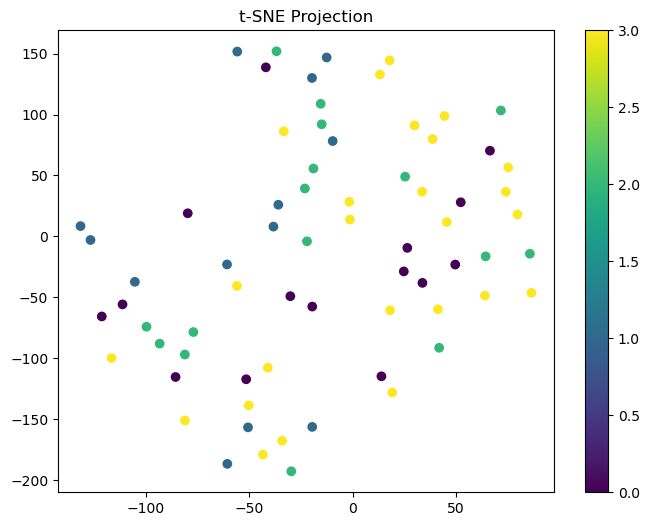

In [35]:
# t-sne visualisation on a 2d 
tsne = TSNE(n_components = 2, random_state = rand_state, learning_rate = 200, perplexity = 10)
X_tsne = tsne.fit_transform(X_train)

plt.figure(figsize = (8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c = y_train, cmap = 'viridis')
plt.title('t-SNE Projection')
plt.colorbar()
plt.show()


No distinct clusters found in the training set. 

In [36]:
# instantiate PCA
pca = PCA(n_components = 4, svd_solver = 'auto')

pca_test_x = pca.fit_transform(X_train)
pca.get_feature_names_out

component_weights = pca.components_

print(pca_test_x.shape)
print("component weights:\n", component_weights)


(69, 4)
component weights:
 [[ 0.33307452  0.46930566  0.18929673  0.21652931 -0.74508135 -0.0036006
   0.0036006  -0.00903876  0.07884224  0.03431488  0.03434419 -0.12104934
   0.03206244 -0.03942285 -0.05494009  0.04488728]
 [ 0.58813746 -0.49739515 -0.39183278 -0.36932189 -0.25378795 -0.10220116
   0.10220116  0.04929935 -0.05397059  0.05522533 -0.01260291 -0.05486359
   0.00313689 -0.09561366  0.10350847  0.0058807 ]
 [-0.35390902 -0.42145212 -0.36625193  0.66182155 -0.31680778 -0.05430362
   0.05430362  0.0252143  -0.01039767 -0.01241828  0.06315601 -0.08981944
  -0.03876881  0.02876302  0.05482807 -0.02055719]
 [ 0.62211477 -0.03102204  0.0341538   0.58996782  0.42461647  0.13383308
  -0.13383308 -0.0065112   0.06406146 -0.07977357 -0.09363879  0.12934156
  -0.0190622  -0.03463708 -0.04423738  0.08445719]]


In [48]:
# map component weights and feature names
weights_names_map = {}

for i, component in enumerate(component_weights):
    component_feature_weights = zip(feature_name, component)
    weights_names_map[f'Component {i + 1}'] = sorted(component_feature_weights, key = lambda x : abs(x[1]), reverse = True)
    
print('features for component 1:')
for feature, weight in weights_names_map['Component 1']:
    print(f'{feature} : {weight}')
    
print('features for component 2:')
for feature, weight in weights_names_map['Component 2']:
    print(f'{feature} : {weight}')

print('features for component 3:')
for feature, weight in weights_names_map['Component 3']:
    print(f'{feature} : {weight}')
    
print('features for component 4:')
for feature, weight in weights_names_map['Component 4']:
    print(f'{feature} : {weight}')
    

features for component 1:
learning_success : -0.7450813511805943
Mean_Q1 : 0.4693056648678441
published_sections : 0.33307452174775065
duration : 0.21652930693825387
Mean_Q4 : 0.1892967254043333
category_Med : -0.12104933841027848
category_Ethik : 0.0788422351524943
category_Studieren : -0.05494008734604911
category_ÜberKI : 0.044887283473821475
category_Schule : -0.03942284640971985
category_ML : 0.03434418860356302
category_Industry40 : 0.03431488428381482
category_Robotik : 0.03206243849663039
category_Data Literacy : -0.00903875784427671
language_en : 0.0036006047217621608
language_de : -0.0036006047217621556
features for component 2:
published_sections : 0.5881374606282568
Mean_Q1 : -0.4973951455542734
Mean_Q4 : -0.3918327783128798
duration : -0.36932189324014325
learning_success : -0.2537879497161371
category_Studieren : 0.1035084719447889
language_de : -0.10220115815543386
language_en : 0.10220115815543383
category_Schule : -0.09561365814617591
category_Industry40 : 0.0552253343

[0.26429213 0.21821866 0.16891978 0.11144705]
Sum_4 components: 0.7628776163299492


<Figure size 800x600 with 0 Axes>

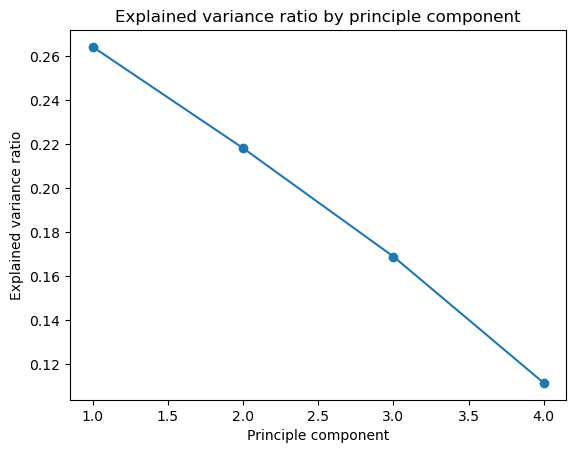

In [37]:
# check explained variance ratio
explained_vratio = pca.explained_variance_ratio_
print(explained_vratio)
print('Sum_4 components:', explained_vratio.sum())


plt.figure(figsize = (8, 6))
fig, ax = plt.subplots()

x = np.arange(1, len(explained_vratio) + 1)
y = explained_vratio

ax.plot(x, y, marker = 'o')

ax.set_xlabel('Principle component')
ax.set_ylabel('Explained variance ratio')
ax.set_title('Explained variance ratio by principle component')
plt.show()


Keeping 4 dimensions is not enough to explain 95% of the variance

In [38]:
# second round of PCA to reduce the dimensions, transform the datasets

pca_reduce = PCA(n_components = 0.95)
X_train_pca = pca_reduce.fit_transform(X_train)

X_validation_pca = pca_reduce.transform(X_validation)
X_test_pca = pca_reduce.transform(X_test)

print(X_train_pca.shape)
print(X_validation_pca.shape)
print(X_test_pca.shape)


(69, 10)
(23, 10)
(23, 10)


## Build classifiers
Logistic Regressor, Ridge classifier
KNN, SVM
Random Forest Classfier (or other ensembles)

In [39]:
# instantiate classifiers one by one

logreg = LogisticRegression(max_iter = 3000, random_state = rand_state)

ridge = RidgeClassifier(max_iter = 3000, random_state = rand_state)
              
knn = KNeighborsClassifier()
             
svm = SVC(max_iter = 3000, random_state = rand_state)

rfc = RandomForestClassifier(random_state = rand_state)



In [41]:
# setup parameters for random serach 
param_logreg = {'C' : np.arange(0.001, 1, 0.05), 'penalty' : ['l1', 'l2', 'elsaticnet'], 'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'], 'multi_class': ['multinomial']}

param_ridge = {'alpha' : np.arange(0.001, 1, 0.05), 'solver' : ['svd', 'cholesky', 'lsqr', 'sag', 'saga', 'lbfgs']}

param_knn = {'n_neighbors' : np.arange(5, 20, 1) , 'p' : np.arange(1, 5, 0.5)}

param_svm = {'C' : np.arange(0.001, 1, 0.05), 'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'], 'degree' : np.arange(2, 5, 1), 'gamma' : ['scale', 'auto'], 'decision_function_shape' : ['ovo', 'ovr']}

param_rfc = {'n_estimators' : np.arange(10, 150, 5), 'criterion' : ['gini', 'entropy', 'log_loss'], 'max_depth' : np.arange(5, 20, 1), 'max_features' : ['sqrt', 'log2'] }



In [42]:
# random search Logisic Regression
logreg_cv = RandomizedSearchCV(estimator = logreg, param_distributions = param_logreg, n_iter = 100, n_jobs = 10, cv = 10, random_state = rand_state)

logreg_search = logreg_cv.fit(X_train_pca, y_train)

# fit the best model
best_logreg = logreg_search.best_estimator_


C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
610 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1160, in fit
    self._validate_params()
  File "C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py", line 581, in _validate_params
    validate_parameter_cons

In [43]:
# random search Rdige Regression
ridge_cv = RandomizedSearchCV(estimator = ridge, param_distributions = param_ridge, n_iter = 100, n_jobs = 10, cv = 10, random_state = rand_state)

ridge_search = ridge_cv.fit(X_train_pca, y_train)

best_ridge = ridge_search.best_estimator_


C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
160 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 1424, in fit
    super().fit(X, Y, sample_weight=sample_weight)
  File "C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 825, in fit
    

In [44]:
# random search K nearest neighbours
knn_cv = RandomizedSearchCV(estimator = knn, param_distributions = param_knn, n_iter = 100, n_jobs = 10, cv = 10, random_state = rand_state)

knn_search = knn_cv.fit(X_train_pca, y_train)

best_knn = knn_search.best_estimator_


In [45]:
# random search Support Vector Machine
svm_cv = RandomizedSearchCV(estimator = svm, param_distributions = param_svm, n_iter = 100, n_jobs = 10, cv = 10, random_state = rand_state)

svm_search = svm_cv.fit(X_train_pca, y_train)

best_svm = svm_search.best_estimator_


In [46]:
# random search random forest classifier
rfc_cv = RandomizedSearchCV(estimator = rfc, param_distributions = param_rfc, n_iter = 100, n_jobs = 10, cv = 10, random_state = rand_state)

rfc_serach = rfc_cv.fit(X_train_pca, y_train)

best_rfc = rfc_serach.best_estimator_


In [47]:
# prediction of the best estimators

# logreg
y_predV_logreg = best_logreg.predict(X_validation_pca)
y_predT_logreg = best_logreg.predict(X_test_pca)

# ridge
y_predV_ridge = best_ridge.predict(X_validation_pca)
y_predT_ridge = best_ridge.predict(X_test_pca)
 
# knn
y_predV_knn = best_knn.predict(X_validation_pca)
y_predT_knn = best_knn.predict(X_test_pca)

# svm
y_predV_svm = best_svm.predict(X_validation_pca)
y_predT_svm = best_svm.predict(X_test_pca)

# rfc
y_predV_rfc = best_rfc.predict(X_validation_pca)
y_predT_rfc = best_rfc.predict(X_test_pca)


In [56]:
# evaluation of the best estimators --> validation set

# accuacy

acc_logreg_v = accuracy_score(y_validation, y_predV_logreg)

acc_ridge_v = accuracy_score(y_validation, y_predV_ridge)

acc_knn_v = accuracy_score(y_validation, y_predV_knn)

acc_svm_v = accuracy_score(y_validation, y_predV_svm)

acc_rfc_v = accuracy_score(y_validation, y_predV_rfc)

print('Accuracy for the models:', 'LogReg:', acc_logreg_v, 'Ridge:', acc_ridge_v, 'KNN', acc_knn_v, 'SVM', acc_svm_v, 'RandomForest', acc_rfc_v)


# recall

recall_logreg_v = recall_score(y_validation, y_predV_logreg, average = 'weighted')

recall_ridge_v = recall_score(y_validation, y_predV_ridge, average = 'weighted')

recall_knn_v = recall_score(y_validation, y_predV_knn, average = 'weighted')

recall_svm_v = recall_score(y_validation, y_predV_svm, average = 'weighted')

recall_rfc_v = recall_score(y_validation, y_predV_rfc, average = 'weighted')

print('Recall for the models:', 'LogReg:', recall_logreg_v, 'Ridge:', recall_ridge_v, 'KNN', recall_knn_v, 'SVM', recall_svm_v, 'RandomForest', recall_rfc_v)


# roc-auc score

auc_logreg_v = roc_auc_score(y_validation, best_logreg.predict_proba(X_validation_pca), average = 'weighted', multi_class = 'ovo')

auc_knn_v = roc_auc_score(y_validation, best_knn.predict_proba(X_validation_pca), average = 'weighted', multi_class = 'ovo')

auc_rfc_v = roc_auc_score(y_validation, best_rfc.predict_proba(X_validation_pca), average = 'weighted', multi_class = 'ovo')

print('Roc-Auc for the models:', 'LogReg:', auc_logreg_v, 'KNN:', auc_knn_v, 'RandomForest', auc_rfc_v)



Accuracy for the models: LogReg: 0.4782608695652174 Ridge: 0.391304347826087 KNN 0.2608695652173913 SVM 0.5217391304347826 RandomForest 0.5652173913043478
Recall for the models: LogReg: 0.4782608695652174 Ridge: 0.391304347826087 KNN 0.2608695652173913 SVM 0.5217391304347826 RandomForest 0.5652173913043478
Roc-Auc for the models: LogReg: 0.6527777777777778 KNN: 0.6473128019323671 RandomForest 0.6608393719806763


In [64]:
# evaluation of the best estimators --> test set

# accuacy

acc_logreg_t = accuracy_score(y_test, y_predT_logreg)

acc_ridge_t = accuracy_score(y_validation, y_predT_ridge)

acc_knn_t = accuracy_score(y_validation, y_predT_knn)

acc_svm_t = accuracy_score(y_validation, y_predT_svm)

acc_rfc_t = accuracy_score(y_validation, y_predT_rfc)

print('Accuracy for the models:', 'LogReg:', acc_logreg_t, 'Ridge:', acc_ridge_t, 'KNN', acc_knn_t, 'SVM', acc_svm_t, 'RandomForest', acc_rfc_t)


# recall

recall_logreg_t = recall_score(y_validation, y_predT_logreg, average = 'weighted')

recall_ridge_t = recall_score(y_validation, y_predT_ridge, average = 'weighted')

recall_knn_t = recall_score(y_validation, y_predT_knn, average = 'weighted')

recall_svm_t = recall_score(y_validation, y_predT_svm, average = 'weighted')

recall_rfc_t = recall_score(y_validation, y_predT_rfc, average = 'weighted')

print('Recall for the models:', 'LogReg:', recall_logreg_t, 'Ridge:', recall_ridge_t, 'KNN', recall_knn_t, 'SVM', recall_svm_t, 'RandomForest', recall_rfc_t)


# roc-auc score

auc_logreg_t = roc_auc_score(y_validation, best_logreg.predict_proba(X_test_pca), average = 'weighted', multi_class = 'ovo')

auc_knn_t = roc_auc_score(y_validation, best_logreg.predict_proba(X_test_pca), average = 'weighted', multi_class = 'ovo')

auc_rfc_t = roc_auc_score(y_validation, best_logreg.predict_proba(X_test_pca), average = 'weighted', multi_class = 'ovo')

print('Roc-Auc for the models:', 'LogReg:', auc_logreg_t, 'KNN:', auc_knn_t, 'RandomForest', auc_rfc_t)


Accuracy for the models: LogReg: 0.6956521739130435 Ridge: 0.34782608695652173 KNN 0.30434782608695654 SVM 0.43478260869565216 RandomForest 0.34782608695652173
Recall for the models: LogReg: 0.34782608695652173 Ridge: 0.34782608695652173 KNN 0.30434782608695654 SVM 0.43478260869565216 RandomForest 0.34782608695652173
Roc-Auc for the models: LogReg: 0.5314009661835749 KNN: 0.5314009661835749 RandomForest 0.5314009661835749


The random forest performs better than the other models. Check the possibilties of boosting performance in from the code below

In [76]:
# split the dataset into training and validation sets

X_t, X_v, y_t, y_v = train_test_split(X, y, test_size = 15, stratify = y, shuffle = True, random_state = rand_state)

print(X_t.shape)
print(X_v.shape)
print(y_t.shape)
print(y_v.shape)


(100, 16)
(15, 16)
(100,)
(15,)


## Without PCA

In [95]:
steps = [('clf',  RandomForestClassifier(random_state = rand_state, n_jobs = -1))]

pipe = Pipeline(steps)

param_clf = {'clf__n_estimators': np.arange(5, 100, 10),\
             'clf__max_depth' : [None] + list(np.arange(3, 25, 1)),\
             'clf__min_samples_split' : np.arange(2, 16, 1),\
             'clf__min_samples_leaf' : np.arange(1, 10, 1), \
             'clf__max_features' : ['sqrt', 'log2', None] + list(np.arange(0.2, 0.9, 0.2)), \
             'clf__max_leaf_nodes' : [None] + list(np.arange(2, 10, 1)),\
             'clf__bootstrap' : [True, False]           
            }


cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 10, random_state = rand_state)

forest_search = RandomizedSearchCV(pipe, param_distributions = param_clf, n_iter = 150, scoring = 'balanced_accuracy', cv = cv, n_jobs = -1, random_state = rand_state)

forest_search.fit(X_t, y_t)

best_forest = forest_search.best_estimator_


In [96]:
# evaluation of the best estimator

## training set check
y_pred_t = best_forest.predict(X_t)

y_pred_t_proba = best_forest.predict_proba(X_t)

recall_t = recall_score(y_t, y_pred_t, average = 'weighted')

auc_t = roc_auc_score(y_t, y_pred_t_proba, average = 'weighted', multi_class = 'ovo')

print(recall_t)
print(auc_t)



0.82
0.9622383252818035


In [97]:
## validation set check
y_pred = best_forest.predict(X_v)

y_pred_proba = best_forest.predict_proba(X_v)

recall_v = recall_score(y_v, y_pred, average = 'weighted')

auc_v = roc_auc_score(y_v, y_pred_proba, average = 'weighted', multi_class = 'ovo')

print(recall_v)
print(auc_v)



0.6
0.7555555555555555


## With PCA

In [ ]:
# pipeline with PCA

steps_pca = 


In [74]:
# PCA of the features

X_t_pca = pca_reduce.fit_transform(X_t)
X_v_pca = pca_reduce.transform(X_v)

print(X_t_pca.shape)
print(X_v_pca.shape)

# re-tune the random search

search = rfc_cv.fit(X_t_pca, y_t)

best_search = search.best_estimator_

# evaluation of the tree
y_pred = best_search.predict(X_v_pca)

y_pred_proba = best_search.predict_proba(X_v_pca)

accuracy = accuracy_score(y_v, y_pred)

auc = roc_auc_score(y_v, y_pred_proba, average = 'weighted', multi_class = 'ovo')

print(accuracy)
print(auc)


0.6666666666666666
0.7842592592592593


In [ ]:
# build pipeline for the best classifier
steps = 